In [1]:
actions = []
images = []
episode_ends = [0]

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import time

In [1]:
from robotics.gym_pusht.envs.pusht import PushTEnv

env = PushTEnv(obs_type="pixels", render_mode="human", goal_pose="random")
teleop = env.teleop_agent()
obs, info = env.reset()

step_in_episode = 0

while True:
    time.sleep(0.1)
    action = teleop.act(obs)

    if action is None:
        env.render()
        continue

    images.append(obs)
    actions.append(action)

    next_obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    obs = next_obs
    step_in_episode += 1

    if terminated or truncated:
        episode_ends.append(episode_ends[-1] + step_in_episode)
        step_in_episode = 0
        obs, _ = env.reset()

/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment gym_pusht/PushT-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


NameError: name 'time' is not defined

In [2]:
env.close()

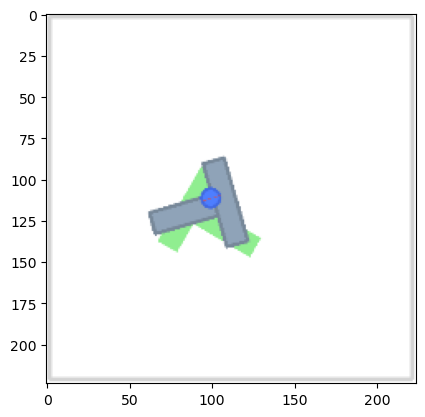

In [28]:
img = images[33]

import matplotlib.pyplot as plt

plt.imshow(img)

# Save dataset snapshot

In [37]:
import zarr
import numpy as np

## Prepare file

In [ ]:
def save_snapshot(actions, images, episode_ends, version):
    file_name = f"./data/demonstrations_snapshot_{version}.zarr"

    actions_np = np.array(actions)
    imgs_np = np.array(images)
    episode_ends_np = np.array(episode_ends)

    file = zarr.open(file_name, mode="w")
    data_group = file.create_group("data")

    # 1) action
    arr_a = data_group.create_array(
        name="action",
        shape=actions_np.shape,
        dtype=actions_np.dtype,
        chunks=actions_np.shape,
    )
    arr_a[:] = actions_np

    # 2) img
    arr_i = data_group.create_array(
        name="img",
        shape=imgs_np.shape,
        dtype=imgs_np.dtype,
        chunks=imgs_np.shape,
    )
    arr_i[:] = imgs_np

    # 3) episode_ends
    arr_e = file.create_array(
        name="episode_ends",
        shape=episode_ends_np.shape,
        dtype=episode_ends_np.dtype,
        chunks=episode_ends_np.shape,
    )
    arr_e[:] = episode_ends_np

In [38]:
dataset_version = 2

file_name = f"./data/demonstrations_snapshot_{dataset_version}.zarr"

## Prepare data

In [39]:
actions_np = np.array(actions)
imgs_np = np.array(images)
episode_ends_np = np.array(episode_ends)

In [ ]:
file = zarr.open(file_name, mode="w")
data_group = file.create_group("data")

# 1) action
arr_a = data_group.create_array(
    name="action",
    shape=actions_np.shape,
    dtype=actions_np.dtype,
    chunks=actions_np.shape,
)
arr_a[:] = actions_np

# 2) img
arr_i = data_group.create_array(
    name="img",
    shape=imgs_np.shape,
    dtype=imgs_np.dtype,
    chunks=imgs_np.shape,
)
arr_i[:] = imgs_np

# 3) episode_ends
arr_e = file.create_array(
    name="episode_ends",
    shape=episode_ends_np.shape,
    dtype=episode_ends_np.dtype,
    chunks=episode_ends_np.shape,
)
arr_e[:] = episode_ends_np

## Test load

In [40]:
import zarr

ds = zarr.open(f"./data/demonstrations_snapshot_{dataset_version}.zarr", mode="r")

actions      = ds["data"]["action"][:]        # shape (N, 2)
images       = ds["data"]["img"][:]           # shape (N, 96, 96, 3)
episode_ends = ds["episode_ends"][:]          # shape (M,)

print("actions:",      actions.shape, actions.dtype)
print("images:",       images.shape,  images.dtype)
print("episode_ends:", episode_ends.shape, episode_ends.dtype)


actions: (9086, 2) int64
images: (9086, 224, 224, 3) uint8
episode_ends: (54,) int64


# Merge snapshots

In [ ]:
def merge_snapshots(version_first, version_second, new_name):
    ds1 = zarr.open(f"./data/demonstrations_snapshot_{version_first}.zarr", mode="r")

    actions_1 = ds1["data"]["action"][:]
    images_1 = ds1["data"]["img"][:]
    episode_ends_1 = ds1["episode_ends"][:]

    ds2 = zarr.open(f"./data/demonstrations_snapshot_{version_first}.zarr", mode="r")

    actions_2 = ds2["data"]["action"][:]
    images_2 = ds2["data"]["img"][:]
    episode_ends_2 = ds2["episode_ends"][:]


    last_item = episode_ends_1[-1]

    new_episode_ends2 = last_item + episode_ends_2

    all_episode_ends = episode_ends_1 + episode_ends_2
    all_images = images_1 + images_2
    all_actions = actions_1 + actions_2

In [7]:
import torch
import os
import numpy as np
import gdown
import zarr



def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class PushTImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_path: str,
                 pred_horizon: int,
                 obs_horizon: int,
                 action_horizon: int):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')

        # float32, [0,1], (N,96,96,3)
        train_image_data = dataset_root['data']['img'][:]
        train_image_data = np.moveaxis(train_image_data, -1,1)
        # (N,3,96,96)

        # (N, D)
        train_data = {
            # first two dims of state vector are agent (i.e. gripper) locations
            'agent_pos': dataset_root['data']['state'][:,:2],
            'action': dataset_root['data']['action'][:]
        }
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        # images are already normalized
        normalized_train_data['image'] = train_image_data

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['image'] = nsample['image'][:self.obs_horizon,:]
        nsample['agent_pos'] = nsample['agent_pos'][:self.obs_horizon,:]
        return nsample


# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['image'].shape:", batch['image'].shape)
print("batch['agent_pos'].shape:", batch['agent_pos'].shape)
print("batch['action'].shape", batch['action'].shape)


/tmp/ipykernel_189128/4182873548.py:87: FutureWarning: Pass mode=r as keyword args. From version 3.1.0 passing these as positional arguments will result in an error
  dataset_root = zarr.open(dataset_path, 'r')


FileNotFoundError: Unable to find group: file://pusht_cchi_v7_replay.zarr.zip